In [1]:
l = [None for i in range(2)]
print(l)

[None, None]


In [1]:
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim
import random
import os

import application_examples.helpers.training as training
import application_examples.helpers.plotting_cnf as plotting_cnf

In [2]:
# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

In [3]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

# Continuous normalising flows: two toy examples

In this notebook we will explore the use of normalising flows to approximate a distribution. We will use two toy examples: a two-modal distribution with two concentric circles, and a uniform distribution on a triangle.

## Hyperparameters

In [4]:
args = {
    'niters': 5000,
    'lr': 1e-3,
    'num_samples': 512,
    'width': 64,
    'hidden_dim': 32,
    'results_dir': 'results'
}

## The Model

Since the examples we'll address are easy, a simple model will suffice. We want the learnt vector field to depend on time. To accomplish this, our model (`CNF`) will call a hypernetwork (`Hypernet`) at each time step. The hypernetwork will take the time as input and output the parameters that will allow `CNF` to compute the vector field.

In [5]:
class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Taken from: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]

In [6]:
def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    
    Taken from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()

class CNF(nn.Module):
    """Continuous normalising flow model.
    
    Taken from: https://github.com/rtqichen/torchdiffeq/blob/master/examples/cnf.py
    """

    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t) # Parameters from the hypernetwork
            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)
            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)  # Basically, f_{theta}(t, z(t))

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)  # -tr(df/dz) -> Instantaneous change of variables theorem

        return (dz_dt, dlogp_z_dt)

A little explanation is in order. CNF is based on a continuous transformation of points z(0) ~ Normal(0, I) through the flow of an ODE defined by a function $f_{\theta}(t, z(t))$, which is a neural network (Given by a part of `CNF` in our case). In order to learn this neural network, we maximise the likelihood function for the distribution at time $t=t_1$. This requires that we know the density of that distribution. We can calculate it using the instantaneous change of variables theorem:
$$
\frac{d}{dt}(\log p(t, z(t))) = -tr(\frac{df_{\theta}}{dz})
$$

The `CNF` class above implements this mechanics: it is the vector field of the system of differential equations that arises. That is, the output of `CNF` is 
$$
CNF ( t, (z(t), \log p(t, z(t)) ) ) =
\left( \begin{array}{c} f_{\theta}(t, z(t)) \\ -tr\left(\frac{df_{\theta}}{dz}(t, z(t))\right) \end{array} \right)
$$
This way, we can calculate $z(t)$ and $\log p(t, z(t))$ at the same time, while also being able to solve it backwards to train.

## Triangle distribution

In [7]:
def point_on_triangle2(pt1, pt2, pt3):
    """
    Random point on the triangle with vertices pt1, pt2 and pt3.
    """
    x, y = random.random(), random.random()
    q = abs(x - y)
    s, t, u = q, 0.5 * (x + y - q), 1 - 0.5 * (q + x + y)
    return (
        s * pt1[0] + t * pt2[0] + u * pt3[0],
        s * pt1[1] + t * pt2[1] + u * pt3[1],
    )


def get_batch(num_samples):
    """
    Generate random points uniformly distributed inside a custom triangle.
    """
    pt1 = [-0.2, 0.0]
    pt2 = [0.6, 0.0]
    pt3 = [0.0, 0.7]

    # Generate random points inside the triangle
    points = [point_on_triangle2(pt1, pt2, pt3) for _ in range(num_samples)]

    x = torch.tensor(points).type(torch.float32)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32)

    return x, logp_diff_t1

### Define the model

In [8]:
t0 = 0  # Initial time
t1 = 10 # Final time

# Definition of the model, optimizer and initial distribution
func = CNF(in_out_dim=2, hidden_dim=args['hidden_dim'], width=args['width']).to(device)
optimizer = optim.Adam(func.parameters(), lr=args['lr'])
# A normal distribution with mean 0 and covariance matrix 0.1 * I
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)

### Train the model

In [9]:
loss_meter = training.RunningAverageMeter()
# Training loop
for itr in range(1, args['niters'] + 1):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(args['num_samples'])  

    z_t, logp_diff_t = odeint(
        func,
        (x, logp_diff_t1),
        torch.tensor([t1, t0]).type(torch.float32).to(device),  
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1] 

    logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    loss = -logp_x.mean(0) 
    

    loss.backward()
    optimizer.step()

    loss_meter.update(loss.item())
    if itr % 100 == 0:
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))

Iter: 100, running avg loss: -0.4017
Iter: 200, running avg loss: -0.8126
Iter: 300, running avg loss: -1.0332
Iter: 400, running avg loss: -1.1272
Iter: 500, running avg loss: -1.1664
Iter: 600, running avg loss: -1.1831
Iter: 700, running avg loss: -1.1936
Iter: 800, running avg loss: -1.2007
Iter: 900, running avg loss: -1.2056
Iter: 1000, running avg loss: -1.2069
Iter: 1100, running avg loss: -1.2124
Iter: 1200, running avg loss: -1.2128
Iter: 1300, running avg loss: -1.2185
Iter: 1400, running avg loss: -1.2222
Iter: 1500, running avg loss: -1.2214
Iter: 1600, running avg loss: -1.2274
Iter: 1700, running avg loss: -1.2248
Iter: 1800, running avg loss: -1.2219
Iter: 1900, running avg loss: -1.2281
Iter: 2000, running avg loss: -1.2286
Iter: 2100, running avg loss: -1.2313
Iter: 2200, running avg loss: -1.2359
Iter: 2300, running avg loss: -1.2348
Iter: 2400, running avg loss: -1.2336
Iter: 2500, running avg loss: -1.2270
Iter: 2600, running avg loss: -1.2325
Iter: 2700, running a

Once again, some further explanation is in order. In the training loop, `odeint` is used to solve backwards the system of differential equations. For the state variable $z(t)$ this is straightforward: given an empiric sample, we want to find the initial condition that will lead to that value at time $t_1$, as we will need it to compute the loss. For the log-probability, we don't have a proper differential equation, simply an integral (since the log p term is not actually on the right-hand side of the equality). Furthermore, we have used 0 as initial condition (from the `get_batch()` function). 

The original equation is as follows:
$$
\log p(t_0, z(t_0)) = \log p(t_1, z(t_1)) - \int_{t_1}^{t_0} tr\left(\frac{df_{\theta}}{dz}(t, z(t))\right) dt
$$

But we are solving (allowing for a slight abuse of notation where we'll write $x$ instead of `logp_diff_t0`):
$$
x = - \int_{t_1}^{t_0} tr\left(\frac{df_{\theta}}{dz}(t, z(t))\right) dt
$$

It is then clear that $x = \log p(t_0, z(t_0)) - \log p(t_1, z(t_1))$, hence the name `logp_diff_t1` for the variable that holds the solution to such integral. 

Then, the line `logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)` is simply the calculation of $\log p(t_0, z(t_0)) - \log p(t_0, z(t_0)) + \log p(t_1, z(t_1)) = \log p(t_1, z(t_1))$, the log-probability of our learnt distribution.

Finally, the loss is simply the negative log-likelihood, as we want to maximise the likelihood of our distribution:
$$
-\frac{1}{N} \sum_{i=1}^N \log p(t_1, z(t_1)_i)
$$
for all samples $z(t_1)_i$ in the batch. This is computed as the mean along the batch dimension: `-logp_x.mean(0)`.

#### Learning curve

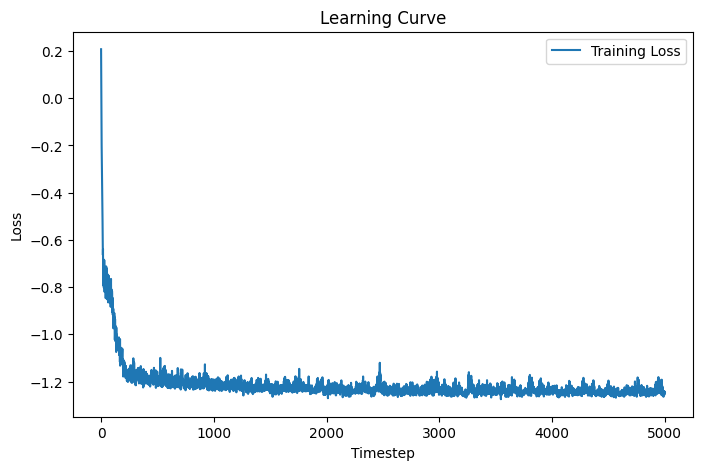

In [10]:
# Visualise the learning curve
loss_meter.plot_history()

#### Save the model

In [11]:
# Save the model
if not os.path.exists(args['results_dir']):
    os.makedirs(args['results_dir'])
torch.save(func.state_dict(), os.path.join(args['results_dir'], 'triangle_cnf.pt'))

### Visualise the results

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

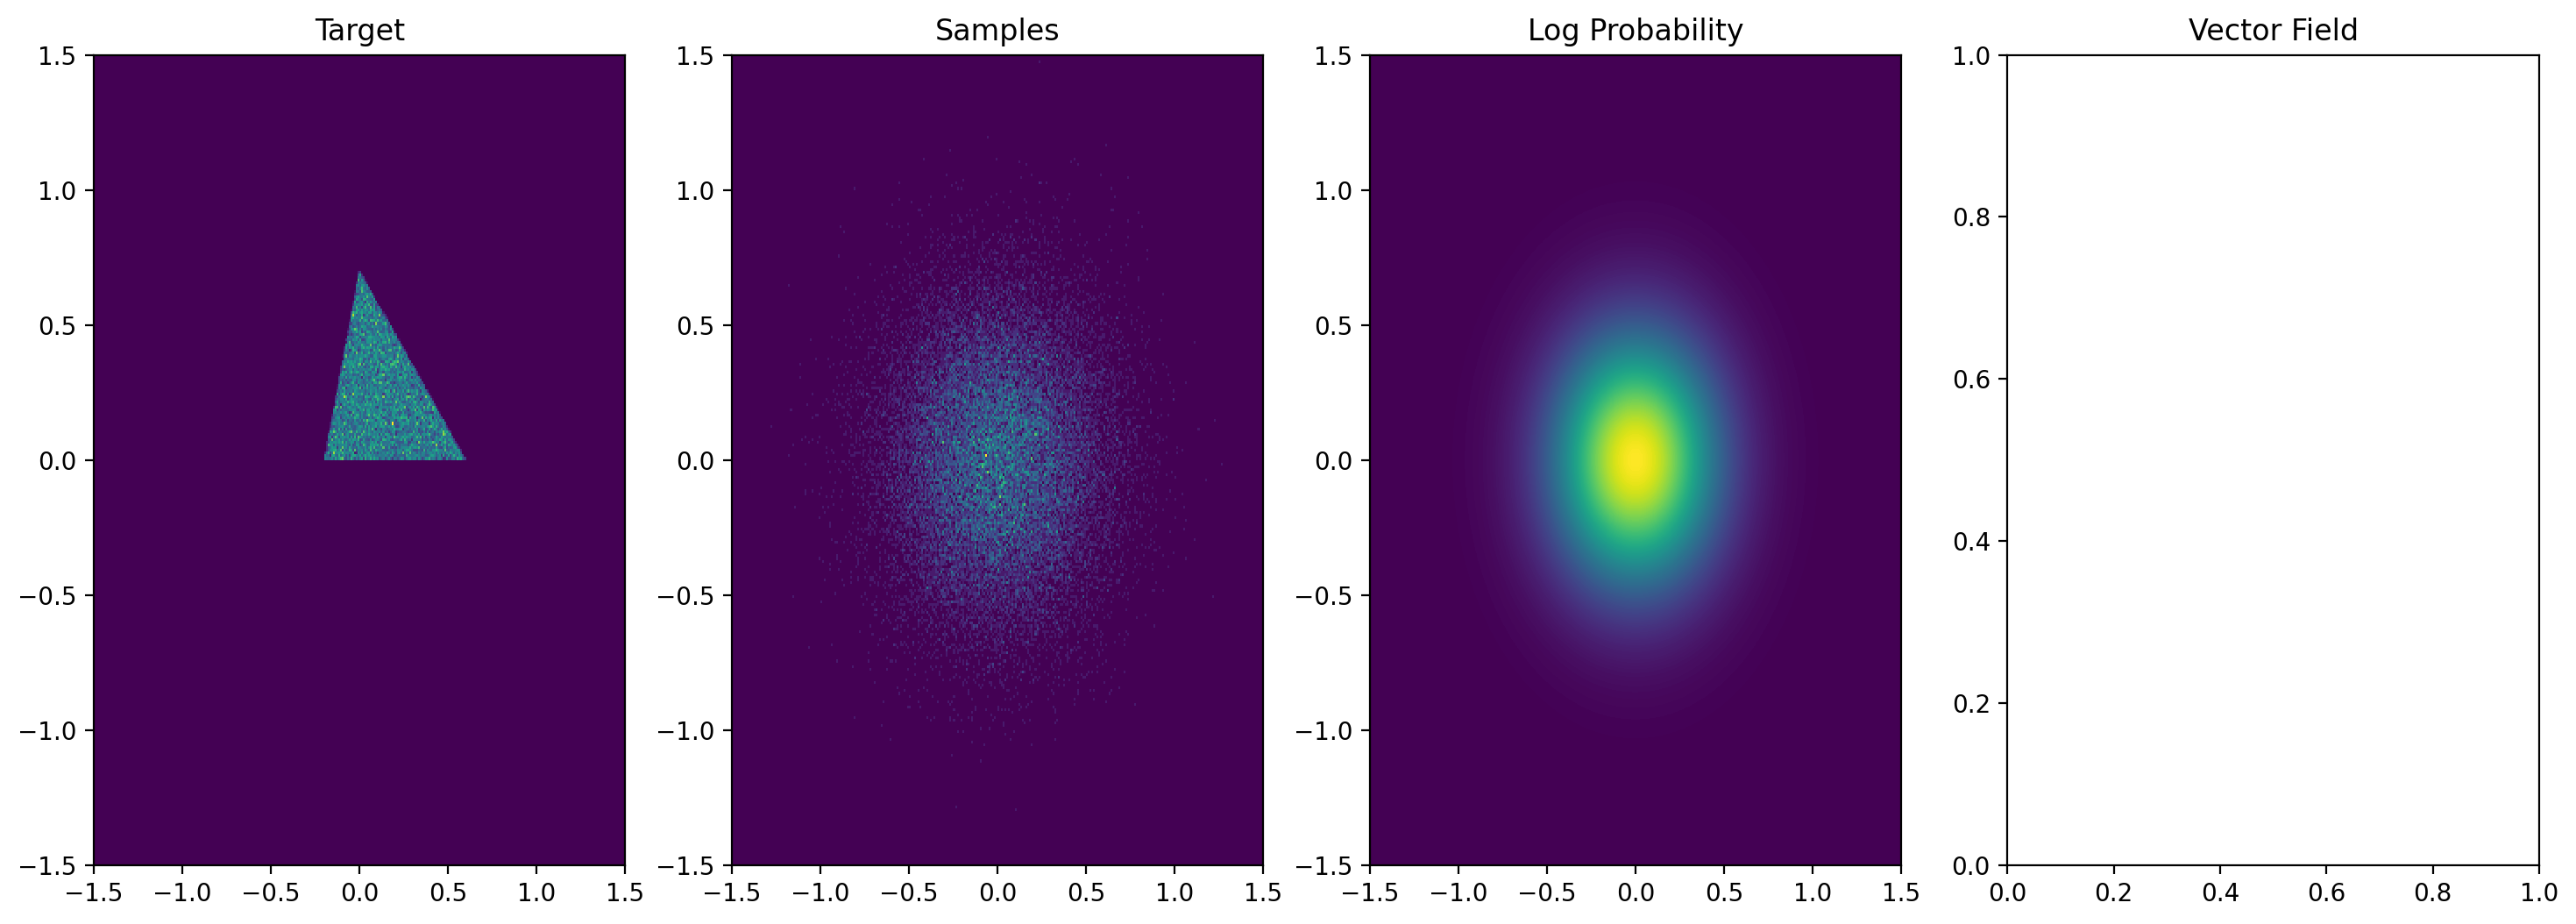

In [9]:
# load model
func.load_state_dict(torch.load(os.path.join(args['results_dir'], 'triangle_cnf.pt')))

plotting_cnf.plot_flow(get_batch, 'triangle_results', odeint, func, p_z0, t0, t1, device)

## Circles distribution

In [13]:
def get_batch(num_samples):
    """
    Generate random points in a two concentric circles distribution.
    """
    points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
    x = torch.tensor(points).type(torch.float32).to(device)
    logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)
    return (x, logp_diff_t1)

### Train the model

In [14]:
t0 = 0  # Initial time
t1 = 10 # Final time

# Definition of the model, optimizer and initial distribution
func = CNF(in_out_dim=2, hidden_dim=args['hidden_dim'], width=args['width']).to(device)
optimizer = optim.Adam(func.parameters(), lr=args['lr'])
# A normal distribution with mean 0 and covariance matrix 0.1 * I
p_z0 = torch.distributions.MultivariateNormal(
    loc=torch.tensor([0.0, 0.0]).to(device),
    covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
)

In [15]:
loss_meter = training.RunningAverageMeter()
# Training loop
for itr in range(1, args['niters'] + 1):
    optimizer.zero_grad()

    x, logp_diff_t1 = get_batch(args['num_samples'])  

    z_t, logp_diff_t = odeint(
        func,
        (x, logp_diff_t1),
        torch.tensor([t1, t0]).type(torch.float32).to(device),  
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

    z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1] 

    logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)
    loss = -logp_x.mean(0) 
    

    loss.backward()
    optimizer.step()

    loss_meter.update(loss.item())
    if itr % 100 == 0:
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))

Iter: 100, running avg loss: 1.9703
Iter: 200, running avg loss: 1.6999
Iter: 300, running avg loss: 1.5650
Iter: 400, running avg loss: 1.4448
Iter: 500, running avg loss: 1.2813
Iter: 600, running avg loss: 1.0896
Iter: 700, running avg loss: 0.9802
Iter: 800, running avg loss: 0.9215
Iter: 900, running avg loss: 0.8908
Iter: 1000, running avg loss: 0.8705
Iter: 1100, running avg loss: 0.8606
Iter: 1200, running avg loss: 0.8600
Iter: 1300, running avg loss: 0.8573
Iter: 1400, running avg loss: 0.8515
Iter: 1500, running avg loss: 0.8444
Iter: 1600, running avg loss: 0.8457
Iter: 1700, running avg loss: 0.8412
Iter: 1800, running avg loss: 0.8415
Iter: 1900, running avg loss: 0.8425
Iter: 2000, running avg loss: 0.8344
Iter: 2100, running avg loss: 0.8372
Iter: 2200, running avg loss: 0.8416
Iter: 2300, running avg loss: 0.8349
Iter: 2400, running avg loss: 0.8295
Iter: 2500, running avg loss: 0.8275
Iter: 2600, running avg loss: 0.8306
Iter: 2700, running avg loss: 0.8259
Iter: 2800

#### Learning curve

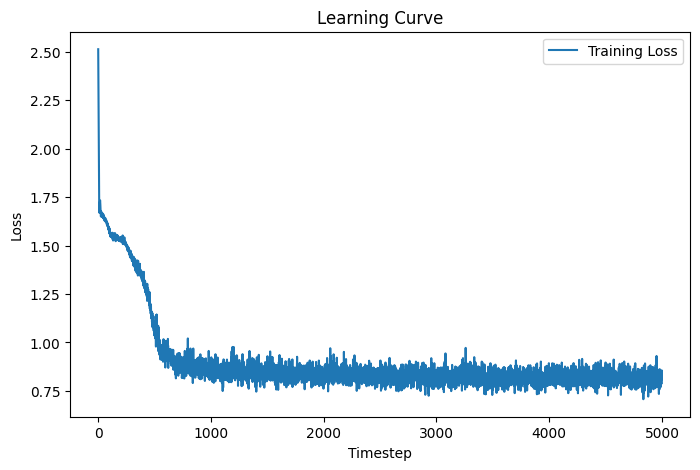

In [16]:
# Visualise the learning curve
loss_meter.plot_history()

#### Save the model

In [17]:
# Save the model
if not os.path.exists(args['results_dir']):
    os.makedirs(args['results_dir'])
torch.save(func.state_dict(), os.path.join(args['results_dir'], 'circles_cnf.pt'))

### Visualise the results

In [18]:
plotting_cnf.plot_flow(get_batch, 'circles_results', odeint, func, p_z0, t0, t1, device)